In [1]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 68.3 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as ku
import matplotlib.pyplot as plt

In [3]:
data = [
    "User: What's the weather like today? Assistant: The weather today is sunny with a high of 25 degrees Celsius.",
    "User: Can you recommend a good restaurant in the city center? Assistant: Sure! One highly recommended restaurant in the city center is 'Foodie Haven.' They offer a variety of cuisines and have received great reviews for their service.",
    "User: How do I change my password for the online banking system? Assistant: To change your password for the online banking system, you can log in to your account, go to the settings menu, and look for the 'Change Password' option. Click on it, and follow the instructions to set a new password.",
    "User: What are the most popular tourist attractions in Paris? Assistant: Paris is known for its many iconic tourist attractions. Some of the most popular ones include the Eiffel Tower, Louvre Museum, Notre-Dame Cathedral, and the Champs-Élysées.",
    "User: How can I improve my programming skills? Assistant: Improving programming skills requires practice and dedication. Here are a few tips: start with the basics, work on small coding projects, collaborate with other programmers, and keep up with the latest trends and technologies in the field.",
    "User: What are the symptoms of the common cold? Assistant: The common cold typically presents with symptoms such as a runny or stuffy nose, sneezing, sore throat, cough, mild headache, and occasionally a low-grade fever.",
    "User: How can I protect my computer from viruses? Assistant: To protect your computer from viruses, make sure to install a reputable antivirus software, keep it up to date, avoid downloading files from untrusted sources, and regularly back up your important data.",
    "User: What are the requirements for obtaining a driver's license? Assistant: The requirements for obtaining a driver's license vary depending on your jurisdiction. Generally, you will need to meet the minimum age requirement, pass a written exam, and pass a practical driving test. Additionally, you may need to provide identification documents and pay the necessary fees."
]

# Split into training and test sets
train_size = int(len(data) * 0.9)
train_data = data[:train_size]
test_data = data[train_size:]

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train_data)
total_words = len(tokenizer.word_index) + 1

# Convert data to sequence of tokens
input_sequences = []
for line in train_data:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create predictors and label
predictors, label = input_sequences[:,:-1], ku.to_categorical(input_sequences[:,-1], num_classes=total_words)

In [4]:
# Quantum part
n_qubits = 4
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    AngleEmbedding(inputs, wires=range(n_qubits))
    StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def qnn_layer():
    return qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

In [5]:
# Building the model
model = Sequential()
model.add(Dense(2, input_shape=(max_sequence_len-1,)))  # Adding this Dense layer to bring down dimensions to 2
model.add(qnn_layer())  # QNN layer
model.add(Dense(total_words, activation='softmax'))

In [6]:
# Compile Model
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(lr=0.01), metrics='accuracy')


In [7]:
# Callback to stop training early if loss does not improve
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [8]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# Train the model
history = model.fit(predictors, label, epochs=15, verbose=1, validation_split=0.1, callbacks=[early_stop])

Epoch 1/15
47/47 [==============================] - 333s 7s/step - loss: 3.5927 - accuracy: 0.0497 - val_loss: 3.5871 - val_accuracy: 0.0602
Epoch 2/15
47/47 [==============================] - 318s 7s/step - loss: 3.5257 - accuracy: 0.0927 - val_loss: 3.5517 - val_accuracy: 0.0843
Epoch 3/15
47/47 [==============================] - 318s 7s/step - loss: 3.4752 - accuracy: 0.0994 - val_loss: 3.4933 - val_accuracy: 0.0542
Epoch 4/15
47/47 [==============================] - 325s 7s/step - loss: 3.4121 - accuracy: 0.1216 - val_loss: 3.4285 - val_accuracy: 0.1205
Epoch 5/15
47/47 [==============================] - 320s 7s/step - loss: 3.3645 - accuracy: 0.1202 - val_loss: 3.3933 - val_accuracy: 0.1265
Epoch 6/15
47/47 [==============================] - 334s 7s/step - loss: 3.3131 - accuracy: 0.1189 - val_loss: 3.3712 - val_accuracy: 0.0783
Epoch 7/15
47/47 [==============================] - 328s 7s/step - loss: 3.2674 - accuracy: 0.1397 - val_loss: 3.3192 - val_accuracy: 0.0904
Epoch 8/15
47

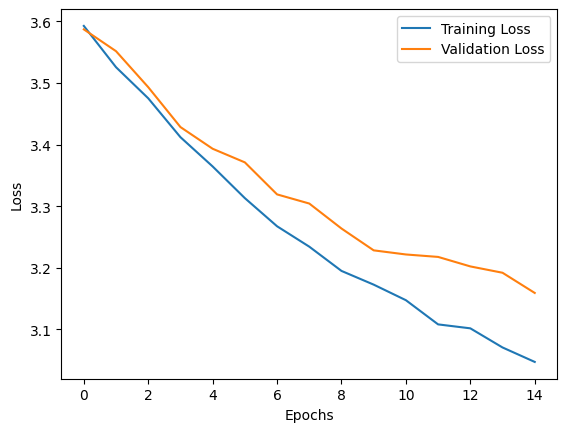

In [9]:
# Training and Validation Loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
# Convert test data to sequence of tokens
input_sequences_test = []
for line in test_data:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences_test.append(n_gram_sequence)

# Pad sequences
input_sequences_test = np.array(pad_sequences(input_sequences_test, maxlen=max_sequence_len, padding='pre'))

# Create predictors and label for testing
predictors_test, label_test = input_sequences_test[:,:-1], ku.to_categorical(input_sequences_test[:,-1], num_classes=total_words)

# Evaluate the model with test data
test_loss, test_acc = model.evaluate(predictors_test, label_test, verbose=2)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)


12/12 - 34s - loss: 3.1059 - accuracy: 0.1270 - 34s/epoch - 3s/step
Test Loss:  3.105931520462036
Test Accuracy:  0.1270270198583603
